### name:Ishikura Yusuke, student number:6930349855

# Explanation of the data
I used Combined Cycle Power Plant Data set[1,2]. The data was collected from a Combined Cycle Power Plant over 6 years, when the power plant was set to work with full load. The objective of this dataset is to predict the net hourly electrical energy output (PE) of the plant from Temperature (T), Exhaust Vacuum (V), Ambient Pressure (AP), Relative Humidity (RH).

[1]Pınar Tüfekci, Prediction of full load electrical power output of a base load operated combined cycle power plant using machine learning methods, International Journal of Electrical Power & Energy Systems, Volume 60, September 2014, Pages 126-140, ISSN 0142-0615.<br>[2]Heysem Kaya, Pınar Tüfekci , Sadık Fikret Gürgen: Local and Global Learning Methods for Predicting Power of a Combined Gas & Steam Turbine, Proceedings of the International Conference on Emerging Trends in Computer and Electronics Engineering ICETCEE 2012, pp. 13-18 (Mar. 2012, Dubai).

In [1]:
import pandas as pd
# load data set
df= pd.read_excel("Folds5x2_pp.xlsx")
print(df)

         AT      V       AP     RH      PE
0     14.96  41.76  1024.07  73.17  463.26
1     25.18  62.96  1020.04  59.08  444.37
2      5.11  39.40  1012.16  92.14  488.56
3     20.86  57.32  1010.24  76.64  446.48
4     10.82  37.50  1009.23  96.62  473.90
...     ...    ...      ...    ...     ...
9563  16.65  49.69  1014.01  91.00  460.03
9564  13.19  39.18  1023.67  66.78  469.62
9565  31.32  74.33  1012.92  36.48  429.57
9566  24.48  69.45  1013.86  62.39  435.74
9567  21.60  62.52  1017.23  67.87  453.28

[9568 rows x 5 columns]


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df[["AT","V","AP","RH"]].values
y = df["PE"].values
#Split data into training and testing
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
#Standarization
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Explanation of regression analyses
I implemented ridge regression, polynomial basis function and gaussian basis function. I defined polynomial basis function and gaussian basis function as follows:
$$
\phi(x) = (x,x^2,\ldots,x^u)\\
\phi(x) = \left(exp\left[-\frac{(x-1/M)^2}{2s^2}\right],exp\left[-\frac{(x-2/M)^2}{2s^2}\right],\ldots,exp\left[-\frac{(x-1)^2}{2s^2}\right]\right)
$$
Here, u,M,s is a hyperparameter.

In ridge regression, the weights is determined to minimize squared loss and the L2 norm of weights. Thus, the objective function is defined as follows:  
$$
\mathrm{min} \ \  L(\boldsymbol{w}) = \frac{1}{2} ||\boldsymbol{t}-\Phi\boldsymbol{w}||^2_2+\frac{\lambda}{2}||\boldsymbol{w}||^2_2,\\
\Phi = \left( \begin{array}{c}1,\cdots,1\\ \boldsymbol{\phi}(\boldsymbol{x}_1),\cdots,\boldsymbol{\phi}(\boldsymbol{x}_N)\end{array}\right)^T,\\
$$
Here, $\boldsymbol{t}$ is the target value vector, $\boldsymbol{x}_1,\ldots,\boldsymbol{x}_N$ are $d$ dimentional data points, $\boldsymbol{w}$ is the weights, $\lambda$ is the reguralization parameter and $\boldsymbol{\phi}(\boldsymbol{x}_i)$ is $m$ dimentional vector.
From this fuction,$\boldsymbol{w}$ is obtained as follows:
$$
\frac{\partial L}{\partial \boldsymbol{w}}=-\Phi^T(\boldsymbol{t}-\Phi\boldsymbol{w})+\lambda \boldsymbol{w}=0,\\
\boldsymbol{w}=(w_0,\ldots,w_m)^T = (\Phi^T\Phi+\lambda I)^{-1}\Phi^T\boldsymbol{t}.
$$
Here, $I$ is identity matrix.Thus, the value is predicted as follows:
$$
t(\boldsymbol{x}) = \boldsymbol{\phi}(\boldsymbol{x})^T(w_1,\ldots,w_m)^T + w_0.
$$
In this method, becouse of reguralization term, overfitting is avoided and numerical stability is added. If we set lambda = 0, this method is equivalent to maximum likelihood.

# Evaluation results

In [3]:
from Ishikura_Ridge import ridge_regression
from Ishikura_Ridge import MSE

## linear basis function


In [4]:
import pandas as pd
import numpy as np

lamda_array = np.array([0,0.1,1,10,100])
mse_result = np.empty((lamda_array.shape[0],2))
loop = 0
for para in lamda_array:
    model = ridge_regression(lamda=para,func="linear")
    model.fit(X_train,y_train)
    pre_t = model.predict(X_train)
    mse_result[loop,0] = MSE(pre_t,y_train)
    pre_t = model.predict(X_test)
    mse_result[loop,1] = MSE(pre_t,y_test)
    loop += 1
linear_result = pd.DataFrame(data=lamda_array,columns=["lambda"])
linear_result[["train_MSE","test_MSE"]] = mse_result
print(linear_result)

   lambda  train_MSE   test_MSE
0     0.0  21.026392  19.733699
1     0.1  21.026392  19.733748
2     1.0  21.026410  19.734205
3    10.0  21.028203  19.740376
4   100.0  21.175069  19.929831


<AxesSubplot:title={'center':'comparison of MSE in linear ridge regression'}, xlabel='lambda', ylabel='MSE'>

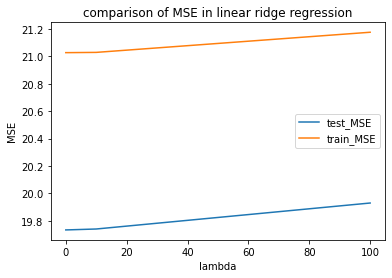

In [5]:
%matplotlib inline
linear_result.plot("lambda", {'train_MSE',"test_MSE"},title="comparison of MSE in linear ridge regression",ylabel="MSE")

In case of linear basis function, because the number of dimention is only 5, lambda hardly affects result. 
Therefore, the mean squared error (MSE) of maximum likelihood and that of ridge regression were almost same.

## gaussian basis function

In [7]:
M_array = np.array([2,3,5,10,30,100,300])

mse_result = np.empty((M_array.shape[0],2))
loop = 0
for basis_para in M_array:
    model = ridge_regression(lamda=0,func="gauss",func_para=basis_para,s=1)
    model.fit(X_train,y_train)
    pre_t = model.predict(X_train)
    mse_result[loop,0] = MSE(pre_t,y_train)
    pre_t = model.predict(X_test)
    mse_result[loop,1] = MSE(pre_t,y_test)
    loop += 1
    if  basis_para == 5:
        w_0 = model.w_
gauss_0 = pd.DataFrame(data=M_array,columns=["M"])
gauss_0["lambda"] = 0
gauss_0[["train_MSE","test_MSE"]] = mse_result 
loop = 0
for basis_para in M_array:
    model = ridge_regression(lamda=1,func="gauss",func_para=basis_para,s=1)
    model.fit(X_train,y_train)
    pre_t = model.predict(X_train)
    mse_result[loop,0] = MSE(pre_t,y_train)
    pre_t = model.predict(X_test)
    mse_result[loop,1] = MSE(pre_t,y_test)
    loop += 1
    if basis_para == 5:
        w_1 = model.w_
gauss_1 = pd.DataFrame(data=M_array,columns=["M"])
gauss_1["lambda"] = 11
gauss_1[["train_MSE","test_MSE"]] = mse_result 
print(gauss_0)
print(gauss_1)

     M  lambda     train_MSE      test_MSE
0    2       0  3.284329e+01  3.159301e+01
1    3       0  1.933423e+01  1.764063e+01
2    5       0  1.792960e+01  1.641063e+01
3   10       0  1.086646e+05  1.027543e+05
4   30       0  1.187962e+07  1.202351e+07
5  100       0  1.668519e+09  1.690891e+09
6  300       0  1.936527e+08  1.800308e+08
     M  lambda  train_MSE   test_MSE
0    2      11  32.844382  31.601755
1    3      11  26.237668  24.914534
2    5      11  23.264762  21.854464
3   10      11  21.670443  20.156600
4   30      11  20.735890  19.109758
5  100      11  19.988996  18.345195
6  300      11  19.242054  17.656912


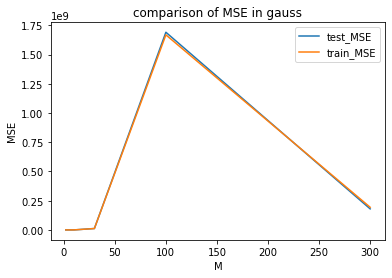

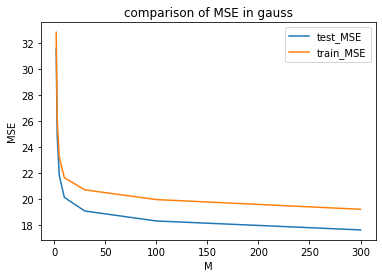

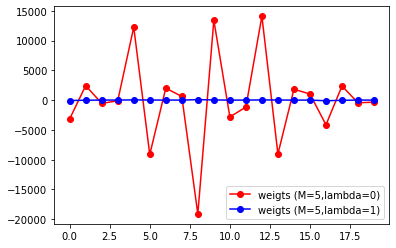

In [8]:
from matplotlib import pyplot as plt

gauss_0.plot("M", {'train_MSE',"test_MSE"},title="comparison of MSE in gauss",ylabel="MSE")
gauss_1.plot("M", {'train_MSE',"test_MSE"},title="comparison of MSE in gauss",ylabel="MSE")
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(w_0, color = 'red', marker = 'o',label="weigts (M=5,lambda=0)")
ax.plot(w_1, color = 'blue', marker = 'o',label="weigts (M=5,lambda=1)")
ax.legend(loc='best')

Using gaussian basis function improved results compared to using linear basis function.
However, without reguralization term, the error is increased rapidly when M is larger than 5.
In this case, the weights is very larger than that of using reguralization term.
When there is the reguralization term, the error is decreased as M is increased.
The best results are obtained with no normalization term, but we think different results can be obtained by varying s.

In [9]:
u_array = np.array([2,3,5,10])
mse_result = np.empty((u_array.shape[0],2))
loop = 0
for basis_para in u_array:
    model = ridge_regression(lamda=0,func="poly",func_para=basis_para,s=1)
    model.fit(X_train,y_train)
    pre_t = model.predict(X_train)
    mse_result[loop,0] = MSE(pre_t,y_train)
    pre_t = model.predict(X_test)
    mse_result[loop,1] = MSE(pre_t,y_test)
    loop += 1
poly_0 = pd.DataFrame(data=u_array,columns=["u"])
poly_0["lambda"] = 0
poly_0[["train_MSE","test_MSE"]] = mse_result 
loop = 0
print(mse_result[2,1])
for basis_para in u_array:
    model = ridge_regression(lamda=1,func="poly",func_para=basis_para,s=1)
    model.fit(X_train,y_train)
    pre_t = model.predict(X_train)
    mse_result[loop,0] = MSE(pre_t,y_train)
    pre_t = model.predict(X_test)
    mse_result[loop,1] = MSE(pre_t,y_test)
    loop += 1
poly_1 = pd.DataFrame(data=u_array,columns=["u"])
poly_1["lambda"] = 1
poly_1[["train_MSE","test_MSE"]] = mse_result 
print(poly_0)
print(poly_1)

16.530503861641325
    u  lambda  train_MSE   test_MSE
0   2       0  18.695590  17.244531
1   3       0  18.274474  16.788503
2   5       0  17.980998  16.530504
3  10       0  17.567044  16.194448
    u  lambda  train_MSE   test_MSE
0   2       1  18.695605  17.244930
1   3       1  18.274514  16.789923
2   5       1  17.981067  16.531456
3  10       1  17.568199  16.200727


<AxesSubplot:title={'center':'comparison of MSE in poly (lambda=1)'}, xlabel='u', ylabel='MSE'>

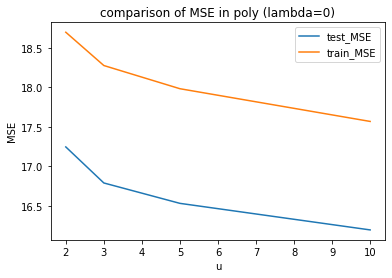

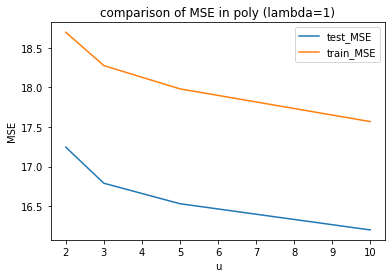

In [10]:
from matplotlib import pyplot as plt

poly_0.plot("u", {'train_MSE',"test_MSE"},title="comparison of MSE in poly (lambda=0)",ylabel="MSE")
poly_1.plot("u", {'train_MSE',"test_MSE"},title="comparison of MSE in poly (lambda=1)",ylabel="MSE")

Using polynomial basis function improved results compared to using linear basis function.
Under d = 10, the error decreases as d increases.